In [ ]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.2",
    temperature=0,
)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
        "system",
        "You are a helpful assistant that creates SQL queries from the schema provided. You will only give the output query and nothing else. ",
    ),
    ("human", "{input}"),
    ]
)


chain = prompt | llm
ai_msg = chain.invoke(
    {
        "input": "Write an sql query to return top 100 companies in the stock market",
    }
)
print(ai_msg.content)

In [ ]:
print(db.table_info)

In [ ]:
from typing import List
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

# Create the prompt
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that has 2 tools one is is_even and other is_prime. Use the tools to give appropriate answer.",
        ),
        ("human", "{input}"),
    ]
)

# Tool 1: Check if a number is even
@tool
def is_even(num: int) -> bool:
    """Returns True if the number is even, otherwise False."""
    return num % 2 == 0

# Tool 2: Check if a number is prime
@tool
def is_prime(num: int) -> bool:
    """Returns True if the number is prime, otherwise False."""
    if num <= 1:
        return False
    if num == 2:
        return True
    if num % 2 == 0:
        return False
    for i in range(3, int(num**0.5) + 1, 2):
        if num % i == 0:
            return False
    return True

# Combine tools
tools = [is_even, is_prime]

# Bind LLM with tools
llm = ChatOllama(model="llama3.2", temperature=0).bind_tools(tools)

# Build the chain
chain = prompt | llm

# Query examples
query = "Is 23 a prime number?"

# Initial message
messages = [HumanMessage(content=query)]

# Run the chain
ai_msg = chain.invoke(messages)
messages.append(ai_msg)

# Check if tool calls are requested
for tool_call in getattr(ai_msg, "tool_calls", []):
    tool_name = tool_call["name"]
    tool_args = tool_call["args"]
    selected_tool = {"is_even": is_even, "is_prime": is_prime}[tool_name]
    tool_result = selected_tool.invoke(tool_args)
    messages.append(ToolMessage(content=str(tool_result), tool_call_id=tool_call["id"]))

# Reinvoke chain with tool result (if needed)
final_response = llm.invoke(messages)
final_response


In [ ]:
import pandas as pd
from typing import List
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
df = pd.read_excel("./Files/Student Schedule Dataset with Dimension Description.xlsx", sheet_name = "Sheet1")

llm = ChatOllama(model="llama3.2", temperature=0)

agent = create_pandas_dataframe_agent(llm, df, verbose=True,allow_dangerous_code=True)

msg = agent.invoke("I am student 1, What courses do I have and what are those names and schedules?",handle_parsing_errors=True)

print(msg["output"])

In [ ]:

import pandas as pd
from typing import List
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
df = pd.read_excel("./Files/Student Schedule Dataset with Dimension Description.xlsx", sheet_name = "Sheet1")

data =df
columns = ['Student ID', 'Student Name', 'Advisor Name', 'Course Code', 'Course Name',
           'Term', 'Instructor Name', 'Days', 'Time', 'Building', 'Room Number', 'Credits']

df_original = pd.DataFrame(data, columns=columns)

# 1. Student Table
df_students = df_original[['Student ID', 'Student Name', 'Advisor Name']].drop_duplicates().reset_index(drop=True)

# 2. Course Table
df_courses = df_original[['Course Code', 'Course Name', 'Credits', 'Instructor Name', 'Days',
                          'Time', 'Building', 'Room Number']].drop_duplicates().reset_index(drop=True)

# 3. Enrollment Table
df_enrollments = df_original[['Student ID', 'Course Code', 'Term']].drop_duplicates().reset_index(drop=True)

# Display the DataFrames
print("=== Students Table ===")
print(df_students)

print("\n=== Courses Table ===")
print(df_courses)

print("\n=== Enrollments Table ===")
print(df_enrollments)


import pandas as pd
from sqlalchemy import create_engine

engine = create_engine('sqlite:///university.db', echo=False)

# Save each DataFrame to the database
df_students.to_sql('students', con=engine, if_exists='replace', index=False)
df_courses.to_sql('courses', con=engine, if_exists='replace', index=False)
df_enrollments.to_sql('enrollments', con=engine, if_exists='replace', index=False)

print("DataFrames successfully stored in the university.db SQLite database.")


In [ ]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase

from langchain_community.agent_toolkits import create_sql_agent
from langchain.agents import AgentType
from langchain import hub
from langchain_ollama import ChatOllama

import pandas as pd
from sqlalchemy import create_engine

engine = create_engine('sqlite:///university.db', echo=False)


db = SQLDatabase.from_uri('sqlite:///university.db',sample_rows_in_table_info =3)

llm = ChatOllama(model="llama3.2")

agent_executor = create_sql_agent(llm,db = db , agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,verbose=True)

db.table_info

In [ ]:
example_query = "I am student 2. Who are the students associated with Advisor 1?"

result = agent_executor.invoke(example_query)


In [11]:
from typing import Dict,TypedDict,List
from langgraph.graph import StateGraph, START, END

In [2]:
class AgentState(TypedDict): # state schema
    name : str
    age: str
    Skills: List[str]
    final: str

In [7]:
def first_node(state: AgentState) -> AgentState:
    """
        This is the first node of the sequence
    """
    state["final"] = f"{state["name"]}, Welcome to the system! "
    return state

def second_node(state: AgentState) -> AgentState:
    """
        This is the second node of the sequence
    """
    state["final"] = state["final"] + f"You are {state["age"]} years old! "
    return state

def third_node(state: AgentState) -> AgentState:
    """
        This is the third node of the sequence
    """
    state["final"] = state["final"] + f"You have skills in: "
    print(state["Skills"])
    l = len(state["Skills"])
    for i,skill in enumerate(state["Skills"]):
        if i == l-2:
            state["final"] = state["final"] + skill 
        elif i == l-1:
            state["final"] = state["final"] + " and " + skill 
        else:
            state["final"] = state["final"] + skill + ", "
    return state

In [8]:
graph = StateGraph(state_schema=AgentState)
graph.add_node("firstNode",first_node)
graph.add_node("secondNode",second_node)
graph.add_node("thirdNode",third_node)

graph.set_entry_point("firstNode")

graph.add_edge("firstNode","secondNode")
graph.add_edge("secondNode","thirdNode")

graph.set_finish_point("thirdNode")



app = graph.compile()

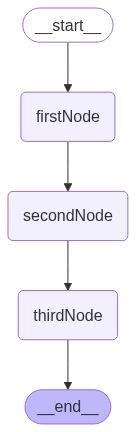

In [9]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
answer = app.invoke({"name": "Bob","age": 15, "Skills": ["Python","Java","SQL"]})
answer["final"]

['Python', 'Java', 'SQL']


'Bob, Welcome to the system! You are 15 years old! You have skills in: Python, Java and SQL'

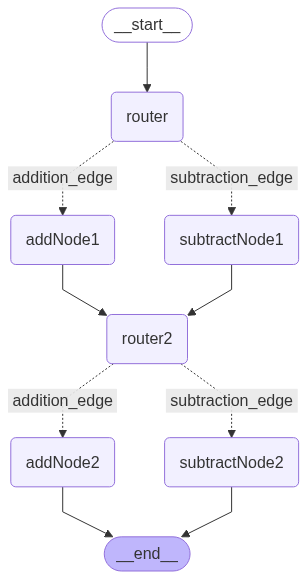

{'num1': 5,
 'operation1': '+',
 'num2': 6,
 'result1': 11,
 'num3': 5,
 'operation2': '-',
 'num4': 6,
 'result2': -1}

In [23]:
from typing import Dict,TypedDict,List
from langgraph.graph import StateGraph, START, END

from IPython.display import Image,display

class AgentState(TypedDict):
    num1 : int
    operation1: str
    num2: int
    result1: int
    num3 : int
    operation2: str
    num4: int
    result2: int


def adder(state:AgentState) -> AgentState:
    """This node adds 2 numbers"""
    state["result1"] = state["num1"] + state["num2"]
    return state

def subtractor(state:AgentState) -> AgentState:
    """This node subtracts 2 numbers"""
    state["result1"] = state["num1"] - state["num2"]
    return state

def adder2(state:AgentState) -> AgentState:
    """This node adds 2 numbers"""
    state["result2"] = state["num3"] + state["num4"]
    return state

def subtractor2(state:AgentState) -> AgentState:
    """This node subtracts 2 numbers"""
    state["result2"] = state["num3"] - state["num4"]
    return state

def decide_next_node1(state:AgentState) -> AgentState:
    """This node will select the next node of the graph"""

    if state["operation1"] == "+":
        return "addition_edge"
    if state["operation1"] == "-":
        return "subtraction_edge"

def decide_next_node2(state:AgentState) -> AgentState:
    """This node will select the next node of the graph"""

    if state["operation2"] == "+":
        return "addition_edge"
    if state["operation2"] == "-":
        return "subtraction_edge"
    

graph = StateGraph(AgentState)

graph.add_node("addNode1", adder)
graph.add_node("subtractNode1", subtractor)
graph.add_node("addNode2", adder2)
graph.add_node("subtractNode2", subtractor2)
graph.add_node("router", lambda state:state)

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router", 
    decide_next_node1,
    {
        "addition_edge" : "addNode1",
        "subtraction_edge": "subtractNode1"
    }
)
graph.add_node("router2", lambda state:state)
graph.add_conditional_edges(
    "router2", 
    decide_next_node2,
    {
        "addition_edge" : "addNode2",
        "subtraction_edge": "subtractNode2"
    }
)
graph.add_edge("addNode1","router2")
graph.add_edge("subtractNode1","router2")
graph.add_edge("addNode2",END)
graph.add_edge("subtractNode2",END)

app = graph.compile()

display(Image(app.get_graph().draw_mermaid_png()))

answer = app.invoke({"num1": 5, "num2": 6, "operation1": "+","num3": 5, "num4": 6, "operation2": "-"})
answer

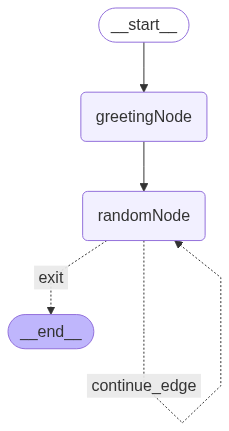

In [ ]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

class AgentState(TypedDict):
    name: str
    counter: int
    randomNumbers: List[int]

def greetingNode(state: AgentState)-> AgentState:
    """ This is a simple Greeting node"""

    state["name"] = f"Hi there. {state["name"]}"
    state["counter"] = 0

    return state

def random_node(state: AgentState)-> AgentState:
    """This node generates a random number from 0 to 10"""
    state["randomNumbers"].append(random.randint(0,10))
    state["counter"] += 1

    return state

def should_continue(state: AgentState)->AgentState:
    """ This edge decides if the loop to continue or not"""

    if state["counter"] < 5:
        return "continue_edge"
    else:
        return "exit"
    
graph = StateGraph(AgentState)

graph.add_node("greetingNode",greetingNode)
graph.add_edge("greetingNode","randomNode")
graph.add_node("randomNode",random_node)

graph.add_conditional_edges(
    "randomNode",
    should_continue,
    {
        "continue_edge": "randomNode",
        "exit" : END
    }
    
)

graph.set_entry_point("greetingNode")
app = graph.compile()


display(Image(app.get_graph().draw_mermaid_png()))



In [30]:
answer = app.invoke({"name": "Yagna","randomNumbers": []})
answer

{'name': 'Hi there. Yagna', 'counter': 5, 'randomNumbers': [10, 6, 7, 2, 7]}

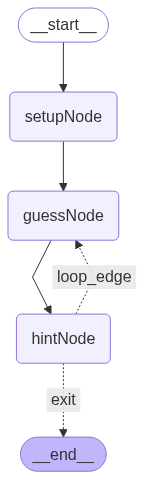

In [51]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict


class AgentState(TypedDict):
    guessed_number: int
    generated_number: int
    attempts_remaining: int
    upper_limit: int
    lower_limit: int
    result: bool

def setupNode(state: AgentState)-> AgentState:
    """This node setups the inital random number and resets the counter"""
    state["generated_number"] = random.randint(1,20)
    state["attempts_remaining"] = 7
    state["result"] = False
    return state

def guessNode(state: AgentState)-> AgentState:
    """This node generates another randomNumber based on result"""
    state["guessed_number"] = random.randint(state["lower_limit"],state["upper_limit"])
    state["attempts_remaining"] -= 1
    return state

def guess_again(state: AgentState) -> AgentState:
    """This Node checks if the guessing should continue or not."""
    print(f"Attempt1 :{state["guessed_number"]} is  guessed number and {state["generated_number"]} is random number ")

    if state["guessed_number"] == state["generated_number"]:
        print("Guessed the number!!")
        state["result"] = True
        return "exit"
    elif state["attempts_remaining"] == 0:
        print(f"Ran out of attempts!! and the number is {state["generated_number"]}")
        state["result"] = False
        return "exit"
    elif state["guessed_number"] > state["generated_number"]: 
        print("Higher")
        state["upper_limit"] = state["guessed_number"]-1
        return "loop_edge"
    elif state["guessed_number"] < state["generated_number"]:
        print("lower")
        state["lower_limit"] = state["guessed_number"]+1
        return "loop_edge"
    
        


graph = StateGraph(AgentState)


graph.add_node("setupNode",setupNode)
graph.set_entry_point("setupNode")
graph.add_node("guessNode",guessNode)
graph.add_node("hintNode",lambda state:state)
graph.add_edge("guessNode","hintNode")
graph.add_edge("setupNode","guessNode")

    
graph.add_conditional_edges(
    "hintNode",
    guess_again,
    {
        "loop_edge": "guessNode",
        "exit": END
    }
)

app = graph.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [53]:
result = app.invoke({"upper_limit": 20, "lower_limit": 1})

Attempt1 :15 is  guessed number and 1 is random number 
Higher
Attempt1 :17 is  guessed number and 1 is random number 
Higher
Attempt1 :16 is  guessed number and 1 is random number 
Higher
Attempt1 :12 is  guessed number and 1 is random number 
Higher
Attempt1 :18 is  guessed number and 1 is random number 
Higher
Attempt1 :5 is  guessed number and 1 is random number 
Higher
Attempt1 :16 is  guessed number and 1 is random number 
Ran out of attempts!! and the number is 1


In [63]:
from typing import Annotated, Sequence, TypedDict, List, Union
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_community.utilities.sql_database import SQLDatabase

load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    chat_history_messages: Annotated[Union[AIMessage,HumanMessage], add_messages]
    user_id: str
    role_db_uri: str
    database: SQLDatabase
    db_schema: str
    db_uri: str
    sql_query: str
    sql_result: str
    sql_error: str

def load_data(user_id,db_uri,user_role,chat_log_file) :
    """ This function loads the user Data into the state after the login."""

    df = pd.read_excel(
        "./Files/Student Schedule Dataset with Dimension Description.xlsx",
        sheet_name="Sheet1"
    )
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    temp_db_URI = db_uri
    engine = engine = create_engine(temp_db_URI, echo=False)
    try:
        if user_role == "student":
            filtered = df[df["student_id"] == user_id]
        elif user_role == "advisor":
            student_ids = df[df["advisor_name"] == user_id]["student_id"].unique()
            filtered = df[df["student_id"].isin(student_ids)]
        elif user_role == "professor":
            student_ids = df[df["instructor_name"] == user_id]["student_id"].unique()
            filtered = df[df["student_id"].isin(student_ids)]
        elif user_role == "admin":
            filtered = df.copy()
        else:
            raise ValueError(f"Unknown role: {user_role}")

        filtered.to_sql("students_details", con=engine, if_exists="replace", index=False)
        
        return user_id,temp_db_URI,user_role,chat_log_file
    
    except Exception as e:
        print(str(e))


def initalizeNode(state: AgentState) -> AgentState:
    """ This node initalizes all the data needed for the graph to answer questions"""
    

    return AgentState

def brainNode(state: AgentState) -> AgentState:
    """ This node accesses the chat log and then tries to simplify the question to make it suitable for an sql query."""

    return AgentState

@tool
def generate_sql_query(question: str, db_schema: str, llm: ChatOllama, error: str, previous_query: str):
    """ This tool takes a user question and database URI and generates the sql query"""

    return ""

@tool
def execute_sql_query(query: str, db: SQLDatabase):
    """ This tool takes the generated sql query and then executes it and returns an error or a result."""

    return ""

def responseNode(state: AgentState) -> AgentState:
    """This node takes the sql_query_result, question and provide an answer in a more understanding way."""

    return AgentState

def should_continue(state: AgentState) -> AgentState:
    """This is a conditional edge which points to which path to take after creating an sql query"""

    if state["messages"]:
        return "continueEdge"
    else:
        return "responseEdge"
    
def build_graph():
    graph = StateGraph(AgentState)
    tools = [execute_sql_query,generate_sql_query]
    graph.add_node("BrainNode", brainNode)
    graph.add_node("initializeNode",initalizeNode)
    graph.add_node("ToolsNode",ToolNode(tools=tools))
    graph.add_node("ResponseNode",responseNode)
    graph.add_conditional_edges("ToolsNode",should_continue,
                                {
                                    "continueEdge": "BrainNode",
                                    "responseEdge": "ResponseNode"
                                })
    graph.add_edge("BrainNode","ToolsNode")
    graph.add_edge("initializeNode","BrainNode")
    graph.set_entry_point("initializeNode")
    graph.set_finish_point("ResponseNode")
    app = graph.compile()
    return app

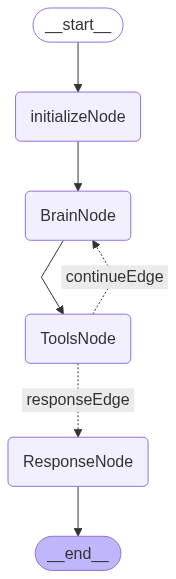

Graph created


In [64]:
from IPython.display import Image,display

app = build_graph()
display(Image(app.get_graph().draw_mermaid_png()))
print("Graph created")